In [14]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#import pytorch_lightning as pl
from torch.autograd import Variable
import logging

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)
torch.set_default_device(device)
device

device(type='cuda')

In [15]:
BATCH_SIZE = 32
LEARNING_RATE = 0.1
NUM_EPOCHS = 150

M = 8
L = 10

dtype_mapping = {
    'Plaintext' : str,
    'Ciphertext' : str,
    'Key' : str
}

def embed(df):
  df['Input'] = df['Plaintext'].astype(str) + df['Ciphertext']
  df = df.drop(columns=['Plaintext', 'Ciphertext'])

  df['Key'] = df['Key'].apply(lambda x : np.array(list(map(int, list(x))), dtype=np.float32))
  df['Input'] = df['Input'].apply(lambda x : np.array(list(map(int, list(x))), dtype=np.float32))

  input = torch.from_numpy(np.vstack(df['Input'].to_numpy()))
  key = torch.from_numpy(np.vstack(df['Key'].to_numpy()))

  return input, key

# Training
df_train = pd.read_csv('S-DES-TRAIN.csv', dtype=dtype_mapping)
#train_loader = DataLoader(embed(df_train), batch_size=len(df_train), num_workers=0)

# Validation
df_val = pd.read_csv('S-DES-VAL.csv', dtype=dtype_mapping)
#val_loader = DataLoader(embed(df_val), batch_size=len(df_val), num_workers=0)

# Testing
df_test = pd.read_csv('S-DES-TEST.csv', dtype=dtype_mapping)
#test_loader = DataLoader(embed(df_test), batch_size=len(df_test), num_workers=0)

In [16]:
class GLU(nn.Module):
  def __init__(self, size):
    super().__init__()
    self.size = size
    self.linear = nn.Linear(size, size * 2)

  def forward(self, x):
    out = self.linear(x)
    return out[:, :self.size] * out[:, self.size:].sigmoid()

class ResidualBlock(nn.Module):
  def __init__(self, in_size):
    super().__init__()
    self.in_size = in_size

    self.block = nn.Sequential(
        nn.BatchNorm1d(in_size),
        nn.ReLU(),
        nn.Linear(in_size, in_size),
        nn.BatchNorm1d(in_size),
        nn.ReLU(),
        nn.Linear(in_size, in_size)
    )

  def forward(self, x):
    return self.block(x)


class SDESModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(2 * M, 128)

    self.block1 = ResidualBlock(128)
    self.block2 = ResidualBlock(128)

    self.output = nn.Linear(128, 2 * L)

    self.glu = GLU(10)

  def forward(self, x):
    y = self.input(x)
    z = self.block1(y)

    w = self.block2(z)
    q = self.output(w + z)

    return q[:, :L] * q[:, L:].sigmoid()



In [ ]:
class GLU(nn.Module):
  def __init__(self, size):
    super().__init__()
    self.size = size
    self.linear = nn.Linear(size, size * 2)

  def forward(self, x):
    out = self.linear(x)
    return out[:, :self.size] * out[:, self.size:].sigmoid()

class LinearLayer(nn.Module):
  def __init__(self, in_size, size):
    super().__init__()
    self.size = size
    self.in_size = in_size

    modules = []
    for _ in range(size):
      modules.append(nn.Linear(in_size, in_size))

    self.fc = nn.Sequential(*modules)

  def forward(self, x):
    return self.fc(x)

class ResidualBlock(nn.Module):
  def __init__(self, in_size):
    super().__init__()
    self.in_size = in_size

    self.block = nn.Sequential(
        nn.BatchNorm1d(in_size),
        nn.ReLU(),
        nn.Linear(in_size, in_size),
        nn.BatchNorm1d(in_size),
        nn.ReLU(),
        nn.Linear(in_size, in_size)
    )

  def forward(self, x):
    return self.block(x)


class SDESModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(2 * M, 128)

    self.block1 = ResidualBlock(128)
    self.block2 = ResidualBlock(128)

    self.output = nn.Linear(128, 2 * L)

    self.glu = GLU(10)

  def forward(self, x):
    y = self.input(x)
    z = self.block1(y)

    w = self.block2(z)
    q = self.output(w + z)

    return q[:, :L] * q[:, L:].sigmoid()



In [17]:
inputs_train, keys_train = embed(df_train)
#inputs_train, keys_train = inputs_train.to(device), keys_train.to(device)
train_set = TensorDataset(inputs_train, keys_train)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=False)

inputs_val, keys_val = embed(df_val)
inputs_val = inputs_val.to(device)
keys_val = keys_val.to(device)


inputs_test, keys_test = embed(df_test)
inputs_test = inputs_test.to(device)
keys_test = keys_test.to(device)



In [18]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()

model = SDESModel()
model = model.to(device)



In [19]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.5, 0.999))
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)

NUM_EPOCHS = 150

def BAP(predictions, targets, l):
  k = targets[:, l]
  k_pred = (predictions[:, l] >= 0.5).float()

  return torch.sum(torch.eq(k, k_pred).float()).cpu().item() / len(df_test)

def BAPLoss(predictions, targets):
  k = targets
  k_pred = (predictions >= 0.5).float()

  return -torch.sum(torch.eq(k, k_pred).float()) / len(df_test)

In [20]:
losses_train = []
losses_validation = []
losses_test = []

baps = [[] for _ in range(L)]

for epoch in range(NUM_EPOCHS):
    # Evaluarea modelului
    model.eval()

    out = model(inputs_test)

    loss = criterion(out, keys_test)
    losses_test.append(loss.item())

    for l in range(L):
     baps[l].append(BAP(out, keys_test, l))

    del out
    torch.cuda.empty_cache()


    # Antrenarea modelului
    model.train()
    for i, (x, target) in enumerate(train_loader):
      optimizer.zero_grad()

      x, target = x.to(device), target.to(device)

      out = model(x)

      loss = criterion(out, target)
      #losses_train.append(loss.item())

      loss.backward()
      optimizer.step()

      del out
      torch.cuda.empty_cache()

      if i % 50 == 0:
        print(f'EPOCH {epoch}, batch {i}, loss {loss.item()}')

    # Validarea modelului
    model.eval()

    out = model(inputs_val)

    loss = criterion(out, keys_val)
    losses_validation.append(loss.item())

    del out
    torch.cuda.empty_cache()

    #scheduler.step()
    print(f'EPOCH {epoch} finished')

EPOCH 0, batch 0, loss 0.5932289361953735
EPOCH 0, batch 50, loss 0.2649742662906647
EPOCH 0, batch 100, loss 0.25223085284233093
EPOCH 0, batch 150, loss 0.2607830762863159
EPOCH 0, batch 200, loss 0.2567443549633026
EPOCH 0, batch 250, loss 0.25659215450286865
EPOCH 0, batch 300, loss 0.25039541721343994
EPOCH 0, batch 350, loss 0.25648173689842224
EPOCH 0, batch 400, loss 0.2515234053134918
EPOCH 0, batch 450, loss 0.2560538947582245
EPOCH 0, batch 500, loss 0.2610515356063843
EPOCH 0, batch 550, loss 0.25473830103874207
EPOCH 0, batch 600, loss 0.2563232481479645
EPOCH 0, batch 650, loss 0.25209471583366394
EPOCH 0, batch 700, loss 0.25037622451782227
EPOCH 0, batch 750, loss 0.25316593050956726
EPOCH 0, batch 800, loss 0.2550985515117645
EPOCH 0, batch 850, loss 0.2513449192047119
EPOCH 0, batch 900, loss 0.2504692077636719
EPOCH 0, batch 950, loss 0.252184122800827
EPOCH 0, batch 1000, loss 0.24994933605194092
EPOCH 0, batch 1050, loss 0.25326603651046753
EPOCH 0, batch 1100, los

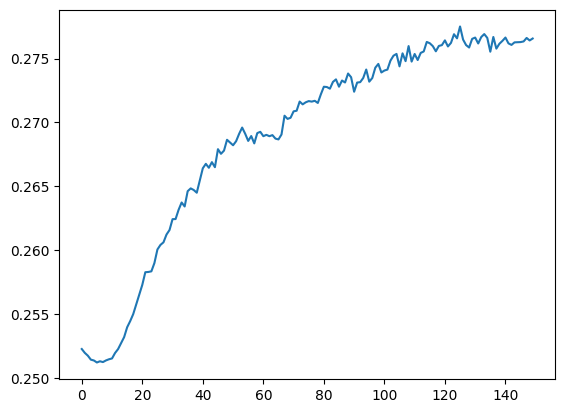

In [31]:
plt.plot(losses_validation)
plt.show()

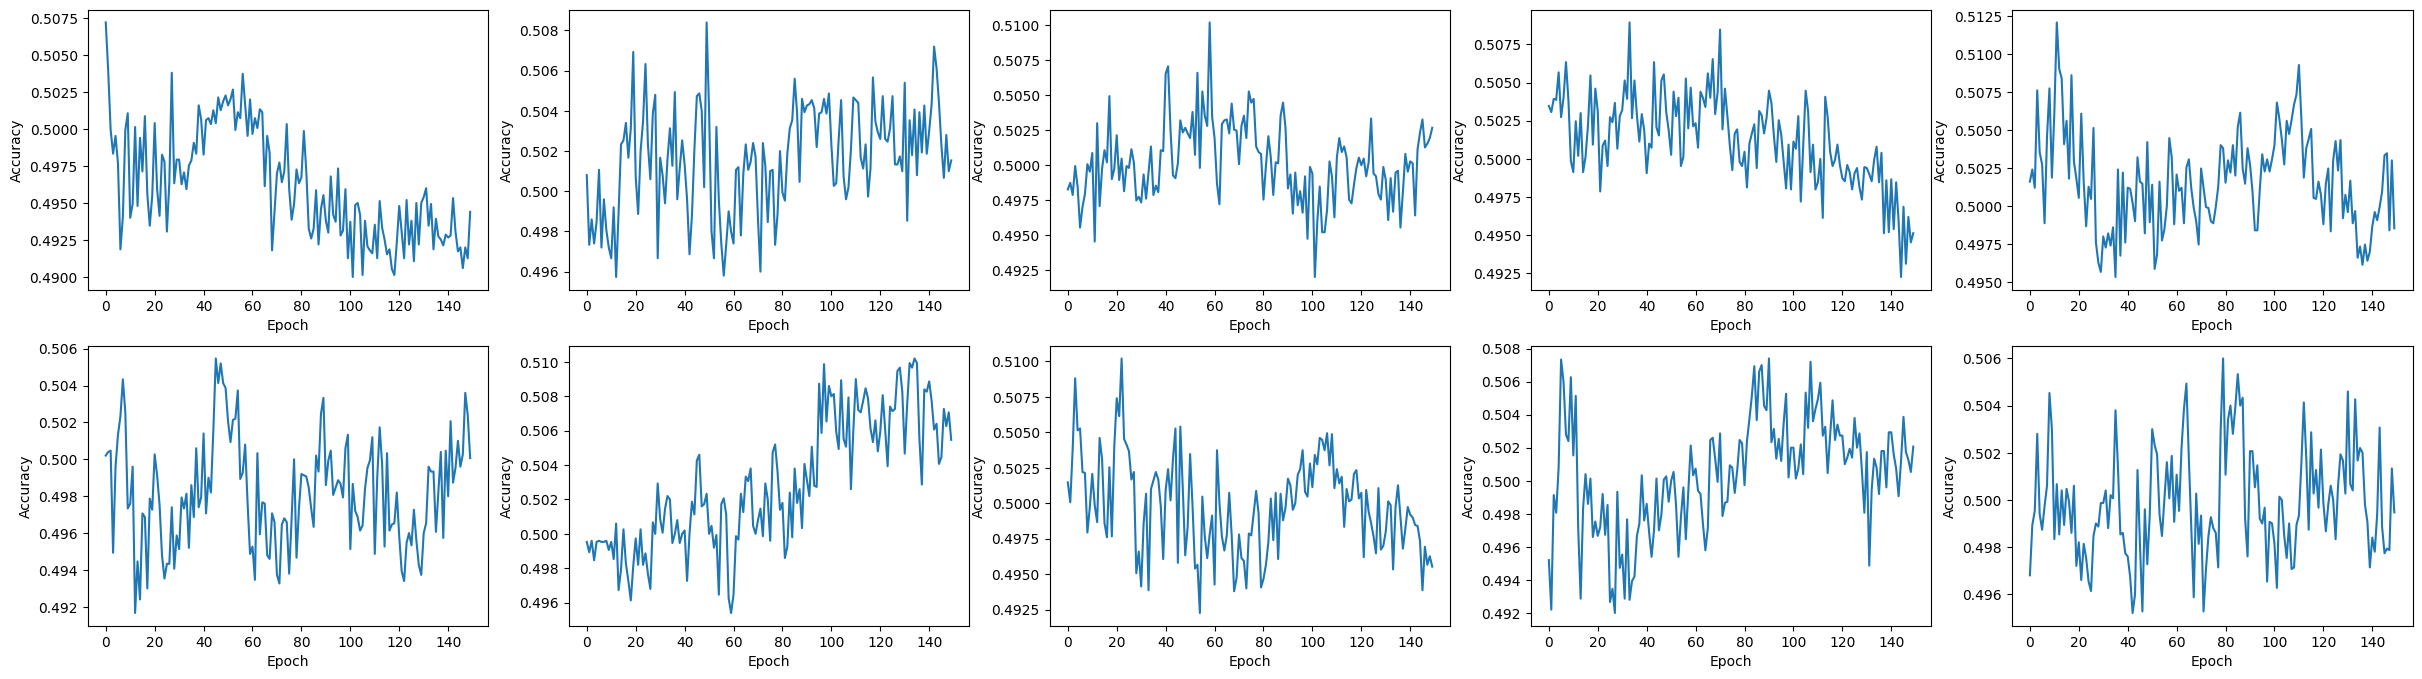

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 8))

for l in range(L):
  axes[l // 5, l % 5].plot(baps[l])
  axes[l // 5, l % 5].set_xlabel('Epoch')
  axes[l // 5, l % 5].set_ylabel('Accuracy')

plt.show()

In [23]:
inputs_test[0]

tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
       device='cuda:0')

In [24]:
keys_test[0]

tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 1.], device='cuda:0')

In [25]:
model.eval()

model(inputs_test[0].unsqueeze(0)).squeeze(0)

tensor([0.7883, 0.6097, 0.9895, 0.2799, 0.0892, 0.6237, 0.4388, 0.6098, 0.6505,
        0.5373], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [26]:
(model(inputs_test[0].unsqueeze(0)).squeeze(0) >= 0.5).float()

tensor([1., 1., 1., 0., 0., 1., 0., 1., 1., 1.], device='cuda:0')